In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import sys
sys.path.append('/code/')
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots

from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
results_dir = '../../results'

## Load thalamus data

In [4]:
obs_wmb = abc.get_combined_metadata()
obs_th = abc.load_standard_thalamus(data_structure='obs')

In [5]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
z_col = 'z'+coords
section_col = 'brain_section_label'

In [6]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

In [7]:
# Precompute boundaries to use multiple times in this notebook w/o need to recompute

# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th[z_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [8]:
# if you reload thalamus_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names('substructure')

In [9]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
# palette_df = pd.read_csv('/code/resources/cluster_palette_glasbey.csv')
abc_palettes['cluster'] = abc.get_thalamus_cluster_palette() #dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

ccf_palette = abc.get_ccf_palette('substructure')
ccf_palette['ZI'] = ccf_palette.pop('ZI-unassigned') # need to fix a key error

## Figure 1: Thalamic cell types vs anatomical annotations

### Figure 1(a): Taxonomy tree

Made in R + Illlustrator

### Figure 1(b): ARA anatomical annotations 

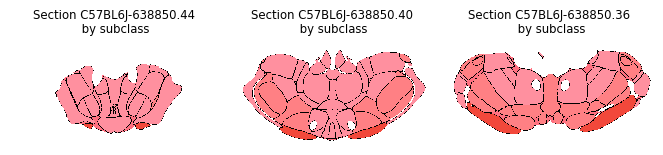

In [10]:
kwargs = dict(
    bg_cells=None,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    point_size=0,
    edge_color="black",
    boundary_img=ccf_boundaries,
    # custom_xy_lims=[2.5, 6, 7, 4],
)

figs_ara = cplots.plot_ccf_overlay(
    obs_th.iloc[:1,:],
    ccf_images,
    point_hue="subclass",
    face_palette=ccf_palette, 
    min_group_count=0,
    sections=cplots.TH_EXAMPLE_SECTION_LABELS,
    separate_figs=False,
    figsize=(20, 5),
    legend=None,
    **kwargs,
)
figs_ara[0].set_size_inches(8.3, 3)
figs_ara[0].savefig(f'{results_dir}/fig1B_ccf_ara.png',
                 transparent=True, bbox_inches='tight', dpi=300)

### Figure 1(c): TH+ZI cell types

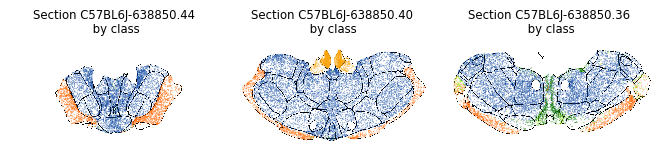

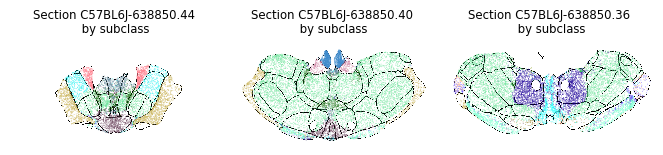

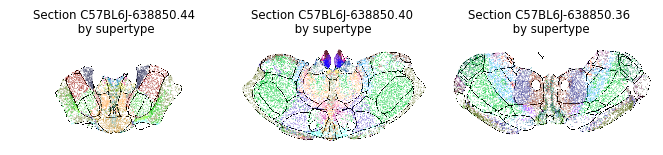

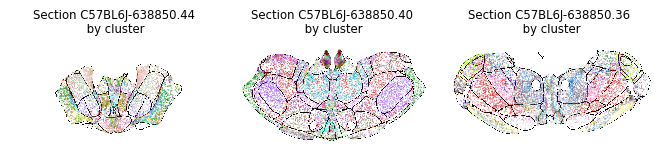

In [11]:
kwargs_celltypes = dict(boundary_img=ccf_boundaries,
                        bg_cells=None,#obs_wmb, # background cells are displayed in grey
                        section_col=section_col,
                        x_col=x_col, 
                        y_col=y_col,
                        edge_color='black',
                        point_size=0.3, # cell marker size
                       )

levels = ['class', 'subclass', 'supertype', 'cluster']
fig_parts = ['C_i', 'C_ii', 'C_iii', 'C_iv']

for i, taxonomy_level in enumerate(levels):
    palette = abc_palettes[taxonomy_level]
        
    figs_ccf_celltypes = cplots.plot_ccf_overlay(
        obs_th, 
        ccf_images, 
        point_hue=taxonomy_level, 
        sections=cplots.TH_EXAMPLE_SECTION_LABELS,
        separate_figs=False,
        point_palette=palette,
        legend=None, #'cells',
        figsize=(20, 5),
        **kwargs_celltypes
    )
    
    figs_ccf_celltypes[0].set_size_inches(8.3, 3)
    
    figs_ccf_celltypes[0].savefig(f'{results_dir}/fig1{fig_parts[i]}_ccf_{taxonomy_level}.pdf',
                                  transparent=True, bbox_inches='tight')